In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, ttest_ind, chi2_contingency
import random
from potosnail import Stats

df = pd.read_csv(r'C:\Users\aacjp\Sales-Scientist\datasets\check6.csv').drop(['Unnamed: 0'], axis='columns')
df.head()

,name,landingPage,customer,domain,model,source,adspend,hardcosts,revenue,avg_polarity,...,global,percentPaid,sales,adRevenue,cac,roas,profit,profitMargin,lpc,averageOrderValue
0,clickfunnels.com,https://funnelscripts.com/funnelscripts-webclass,1,marketing,software,word of mouth,70000,5000000,9000000,0.219405,...,1270,0.353865,30303,8.958190e+06,0.038501,127.974142,3930000,0.436667,21736.00000,3006.752577
1,kinobody.com,https://go.kinobody.com/quiz/,1,fitness,info,word of mouth,210000,20000,630000,0.067753,...,88504,0.121291,9130,5.145120e+05,138.980807,2.450057,400000,0.634921,105833.00000,9.700074
2,FrankKern.com,https://frankkernbook.com/optin24883998?utm_so...,1,entrepreneurship,info,NaN,54437,18666,583310,0.000000,...,120191,0.174400,194,7.174713e+04,280.000000,1.317985,510207,87.470000,2198.00000,996.810407
3,ImpactTheory.Com,NaN,1,self-development,media,NaN,126095,8000,250000,0.288006,...,211062,0.140200,25773,3.057500e+04,5.000000,0.242476,115905,46.360000,10787.69697,297.007329
4,digitalmillionairesecrets.com,https://highticketselling.com/,1,entrepreneurship,info,NaN,139711,53333,1666667,0.345833,...,5225501,0.656100,1672,1.380500e+06,84.000000,9.881112,1473623,88.420000,113.00000,1996.005988


# EDA Questions
1. does having a high lpc (landing page complexity) have a negative relationship with roas (return on adspend)? What about for trigger words number of words, and number of links per landing page?
2. What range accuratley represents the closing rate? In more technical terms, what is the 95% confidence interval?
3. What range accuratley represents the revenue of customers? In more technical terms, what is the 95% confidence interval? What about 68%?
4. Test for signifigant difference in adspend based on the lead's business models and whether or not they closed. AKA Chai-Squared Test.
5. how does twitter sentiment map onto the change in the number of monthly visits?
6. what is the revenue of the leads with the highest ranked websites? run bootsrap sampling to see if there's a signifigant difference.

# 1. does having a high lpc (landing page complexity) have a negative relationship with roas (return on adspend)? What about for trigger words number of words, and number of links per landing page?

## What is LPC exactly?

Landing complexity is calculated with the following formula...

**number of words * number of trigger words * number of links**

trigger words are words that trigger a call to action such as call, book, free, today, session, etc. This formula allows us to gauge the user experiences because the more words, cta's, and places for a user to click the more overwhelmed tha user will feel and therefore less likley to convert. When purchases are the goal this is an important thing to look out for but less important if the main goal is reach / awareness.

In [2]:
x = np.array(df['lpc'])
y = np.array(df['roas'])

lpc and roas has a positive correlation

In [3]:
np.corrcoef(x, y=y)

array([[1.        , 0.03356925],
       [0.03356925, 1.        ]])

Number of words in landing page and roas have a weak negative correlation

In [4]:
x = np.array(df['words'])
y = np.array(df['roas'])
np.corrcoef(x, y=y)

array([[ 1.        , -0.09007687],
       [-0.09007687,  1.        ]])

Number of trigger words in landing page and roas have a weak negative correlation

In [5]:
x = np.array(df['triggers'])
y = np.array(df['roas'])
np.corrcoef(x, y=y)

array([[ 1.        , -0.02151948],
       [-0.02151948,  1.        ]])

Number of links in landing page have a weak positive correlation

In [6]:
x = np.array(df['links'])
y = np.array(df['roas'])
np.corrcoef(x, y=y)

array([[1.        , 0.02006478],
       [0.02006478, 1.        ]])

## findings

number of words and number of trigger words (trigger a call to action) have a slight negative correlation, leading to slightly lower roas. However number of links in the landing page has a slight positive correlation with roas, not what was excpected, however at 2% correlation this is negligible.

Text(0.5, 1.0, 'How many words is too many?')

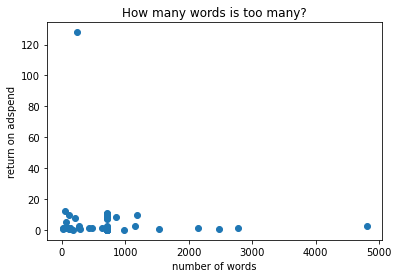

In [7]:
plt.scatter(df['words'], df['roas'])
plt.xlabel('number of words')
plt.ylabel('return on adspend')
plt.title('How many words is too many?')

Text(0.5, 1.0, 'How many trigger words is too many?')

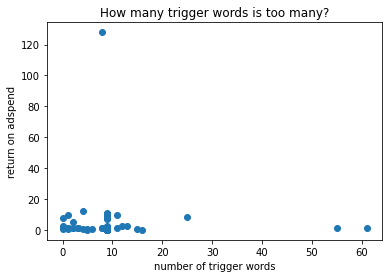

In [8]:
plt.scatter(df['triggers'], df['roas'])
plt.xlabel('number of trigger words')
plt.ylabel('return on adspend')
plt.title('How many trigger words is too many?')

Text(0.5, 1.0, 'Do links boost roas?')

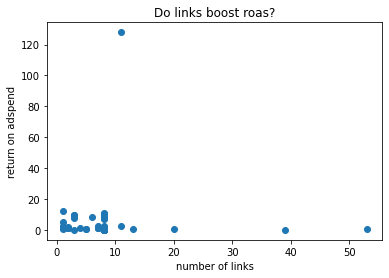

In [9]:
plt.scatter(df['links'], df['roas'])
plt.xlabel('number of links')
plt.ylabel('return on adspend')
plt.title('Do links boost roas?')

In [10]:
under_700 = df.loc[df['words']<700]
over_700 = df.loc[df['words']>=700]

In [11]:
p_thresh = 0.05
ttest_ind(under_700['roas'], over_700['roas']), p_thresh #using a t-test because our samples have 30 datapoints or less

(Ttest_indResult(statistic=0.9907182819962105, pvalue=0.3260102942525549),
 0.05)

we failed to reject the null hypothesis, but we'll do some more digging

In [12]:
np.mean(under_700['roas']), np.mean(over_700['roas'])

(8.239649538863633, 3.7932887841891887)

In [13]:
np.median(under_700['roas']), np.median(over_700['roas'])

(1.2465181955, 1.274138918)

In [14]:
def bootstrap(x):
    '''preforms a single iteration of the bootstrap sampling technique'''
    samples = []
    for i in range(len(x)):
        sample = random.sample(x, 1)[0]
        samples.append(sample)
    return samples

Text(0.5, 1.0, 'roas of leads with under 700 words in the landing page')

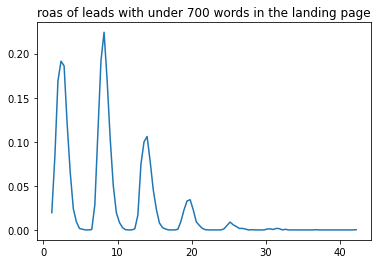

In [15]:
from potosnail import Stats
bootstrap(list(under_700['roas']))

xbars = []
for i in range(10000): #augmenting our population to 10k samples
    xbars.append(np.mean(bootstrap(list(under_700['roas']))))
Stats().PDF(xbars)
plt.title('roas of leads with under 700 words in the landing page')

Text(0.5, 1.0, 'roas of leads with over 700 words in the landing page')

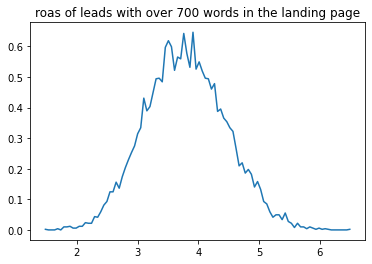

In [16]:
bootstrap(list(over_700['roas']))

xbars = []
for i in range(10000):
    xbars.append(np.mean(bootstrap(list(over_700['roas']))))
Stats().PDF(xbars)
plt.title('roas of leads with over 700 words in the landing page')

In [17]:
df.loc[df['roas']==max(df['roas'])] #lead with the highest roas, it's clickfunnels

,name,landingPage,customer,domain,model,source,adspend,hardcosts,revenue,avg_polarity,...,global,percentPaid,sales,adRevenue,cac,roas,profit,profitMargin,lpc,averageOrderValue
0,clickfunnels.com,https://funnelscripts.com/funnelscripts-webclass,1,marketing,software,word of mouth,70000,5000000,9000000,0.219405,...,1270,0.353865,30303,8958189.977,0.038501,127.974142,3930000,0.436667,21736.0,3006.752577


## Actionable insight
if a lead's landing page has more than 700 words it is an indicator that their roas is low and there's a leak in their adspend, meaning we could save them a higher percentage of adspend. As a result we can prioritize these leads, reps should ask these prospects questions that reveal if the prospect is unsatisfied with their current roas. Additionally reps can use 'fixing leaks in adspend' as a selling point. We should also note that leads with under 700 word landing pages have more variance and are sparked by outliers with very high roas.

in a nutshell...
* prioritize leads with 700+ words in their landing page
* leverage the leaky adspend pain point for these prospects
* offer advice on how to clean up the landing page to provide value upfront

# 2. What range accuratley represents the closing rate? In more technical terms, what is the 95% confidence interval?

In [21]:
import random 

def GetCI(pop, n, ss=30, t=2):
    '''returns the confidence interval of a population'''
    x = []
    for i in range(n):
        sample = random.sample(pop, ss)
        x.append(sum(sample)/len(sample))
    xbar = np.mean(x)
    sigma = np.std(x)
    minimum = xbar - (sigma*t)
    maximum = xbar + (sigma*t)
    return minimum, maximum, x

In [22]:
minimum, maximumn, x = GetCI(list(df['customer']), 1000)
minimum, maximumn

(0.3874537727255918, 0.6331462272744082)

Text(0.5, 0, 'closing rates of samples')

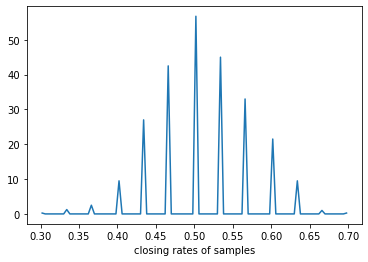

In [23]:
Stats().PDF(x)
plt.xlabel('closing rates of samples')

Based on the data we are 95% confident that our closing rate is between 38% and 63%. Do keep in mind that this dataset does not accuratley represent the customer base and the closing rate is likley a good bit lower.

# 3. What range accuratley represents the revenue of customers? In more technical terms, what is the 95% confidence interval? What about 68%?

In [27]:
customers = df.loc[df['customer']==1] #selecting all the leads who purchased
GetCI(list(customers['revenue']), 10, ss=16)[:2]

(486866.47723421035, 6219706.66026579)

##### We have 95% confidence that our customers generate between 486,000 than 6.2 million dollars per month on average

In [29]:
GetCI(list(customers['revenue']), 10, ss=16, t=1)[:2]

(1912581.2169082924, 4697155.108091708)

We have 68% confidence that our customers generate 1.9 to 4.7 million dollars per month on average

In [30]:
customers.loc[customers['revenue']<=1900000]

,name,landingPage,customer,domain,model,source,adspend,hardcosts,revenue,avg_polarity,...,global,percentPaid,sales,adRevenue,cac,roas,profit,profitMargin,lpc,averageOrderValue
1,kinobody.com,https://go.kinobody.com/quiz/,1,fitness,info,word of mouth,210000,20000,630000,0.067753,...,88504,0.121291,9130,5.145120e+05,138.980807,2.450057,400000,0.634921,105833.00000,9.700074
2,FrankKern.com,https://frankkernbook.com/optin24883998?utm_so...,1,entrepreneurship,info,NaN,54437,18666,583310,0.000000,...,120191,0.174400,194,7.174713e+04,280.000000,1.317985,510207,87.470000,2198.00000,996.810407
3,ImpactTheory.Com,NaN,1,self-development,media,NaN,126095,8000,250000,0.288006,...,211062,0.140200,25773,3.057500e+04,5.000000,0.242476,115905,46.360000,10787.69697,297.007329
4,digitalmillionairesecrets.com,https://highticketselling.com/,1,entrepreneurship,info,NaN,139711,53333,1666667,0.345833,...,5225501,0.656100,1672,1.380500e+06,84.000000,9.881112,1473623,88.420000,113.00000,1996.005988
6,ShopaNova.com,https://shopanova-and-me.com/shopanova-home-pa...,1,ecommerce,software,NaN,100000,200000,333333,0.000000,...,5225496,0.210243,167,1.283670e+05,599.000000,1.283670,33333,10.000000,17.00000,296.998123
7,SamCart.io,https://try.samcart.com/passive-income-with-co...,1,ecommerce,software,NaN,218815,450000,750000,0.072365,...,5225501,0.323200,7576,2.575500e+05,29.000000,1.177022,81185,10.820000,75.00000,197.036453
8,billygeneismarketing.com,https://www.getbillysadvantage.com/free-traini...,1,entrepreneurship,info,NaN,116155,12799,399984,0.103704,...,270673,0.210243,2030,1.516740e+05,57.000000,1.305790,271030,67.760000,47.00000,999.960000
9,Ladyboss.com,https://go.ladyboss.com/content/FsBWWFycvPFLmo2,1,fitness,info,NaN,521329,30399,949962,0.041987,...,338734,0.357900,950,4.018340e+05,549.000000,0.686967,561427,59.010000,298.00000,39.989812
10,GymLaunch.com,NaN,1,entrepreneurship,info,NaN,97574,10752,336000,0.103704,...,2812988,0.210243,56,1.112830e+05,1742.000000,1.140498,227674,67.760000,10787.69697,3000.000000
11,SmarterNutrition.com,https://try.smarternutrition.com/collagen/,1,fitness,ecommerce,NaN,45035,27475,78500,0.000000,...,632196,0.210243,1963,3.227900e+04,23.000000,0.716754,5990,7.630000,2506.00000,799.359712


In [31]:
customers.loc[customers['revenue']>=4700000]

,name,landingPage,customer,domain,model,source,adspend,hardcosts,revenue,avg_polarity,...,global,percentPaid,sales,adRevenue,cac,roas,profit,profitMargin,lpc,averageOrderValue
0,clickfunnels.com,https://funnelscripts.com/funnelscripts-webclass,1,marketing,software,word of mouth,70000,5000000,9000000,0.219405,...,1270,0.353865,30303,8958189.977,0.038501,127.974142,3930000,0.436667,21736.00000,3006.752577
16,groovelife.com,https://groovelife.com/collections/new-womens-...,1,apparel,ecommerce,NaN,2332049,3237500,9250000,0.000000,...,93743,0.638900,205556,5595325.000,11.000000,2.399317,3680451,39.790000,4820.00000,2976.190476
24,gatestonebpo.com,NaN,1,finance,consulting,NaN,2558334,0,51166667,0.103704,...,2480630,0.210243,8000,6140000.000,320.000000,2.399999,45026667,88.000000,10787.69697,1997.000000


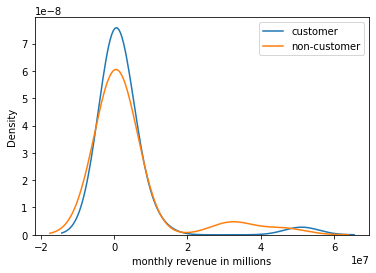

In [32]:
sns.kdeplot(x=customers['revenue'], label='customer')
sns.kdeplot(x=df.loc[df['customer']==0]['revenue'], label='non-customer')
plt.xlabel('monthly revenue in millions')
plt.legend()

## takeaway...

our leads that convert are most likley to be between 1 million and 50 million in annual revenue.

# 4. Test for signifigant difference in adspend based on the lead's business models and whether or not they closed.

Test 1: do customers and non-customers spend the same on ads?

H0: customers and non-customers spend the same on ads.

H1: customers and non-customers do not spend the same on ads.

p-threshold: 0.05

In [33]:
customers = list(df.loc[df['customer']==1]['adspend'])[:-1]
non_customers = list(df.loc[df['customer']==0]['adspend'])
ttest_ind(customers, non_customers) #switch to ttest

Ttest_indResult(statistic=-0.8854464974820433, pvalue=0.3797022330066696)

In [34]:
customers = list(df.loc[df['customer']==1]['revenue'])[:-1]
non_customers = list(df.loc[df['customer']==0]['revenue'])
#print(chisquare(customers, f_exp=non_customers)) #switch to ttest
#print(np.mean(customers), np.mean(non_customers))
ttest_ind(customers, non_customers)

Ttest_indResult(statistic=-0.518814709809123, pvalue=0.6059342130160463)

We fail to reject the null hypothesis that customers and non-customers spend the same on ads.

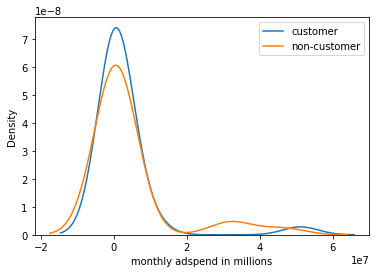

In [35]:
sns.kdeplot(x=customers, label='customer')
sns.kdeplot(x=non_customers, label='non-customer')
plt.xlabel('monthly adspend in millions')
plt.legend()

Test 1: is there a relationship between business model and closing?

H0: there is no relationship between business model and closing.

H1: there is a relationship between business model and closing.

p-threshold: 0.05

In [36]:
ct = pd.crosstab(df.customer, df.model, margins=True)
ct

model,consulting,ecommerce,info,media,software,All
customer,,,,,,
0,12,5,5,2,5,29
1,8,2,14,1,5,30
All,20,7,19,3,10,59


In [37]:
obs = np.array([ct.iloc[0][:-1], ct.iloc[1][:-1]])

In [38]:
chi2_contingency(obs)[:3] #we use a chi square contigency test because we are checking if categorical features 
# are dependant on eachother

(6.667171664794171, 0.15455728165839155, 4)

We fail to reject the null hypothesis that business model and closing are independant of eachother.

## Insights

1. Our customers tend to generate less revenue and spend less on ads. The likley reason for this is because they have leaner business models and have a more efficient adspend thanks to the Hyros Software, large companies may also be overrepresenting the non-customer population. 

2. Although most of our customers run info businesses centered around courses and coaching we were not able to staistically prove a relationship between business model and closing.

# 5. how does twitter sentiment map onto roas?

## What is sentiment?

In this context sentiment is on ascale from -1 to 1 and quantifies the emotions expressed to a particular topic. In this case each topic is the lead and the sentiment or avg_polarity is the sum average of the sentiments of all the tweets towards each lead.

In [39]:
x = np.array(df['avg_polarity'])
y = np.array(df['roas'])
np.corrcoef(x, y=y)

array([[1.        , 0.15895215],
       [0.15895215, 1.        ]])

Text(0.5, 0, 'average twitter sentiment')

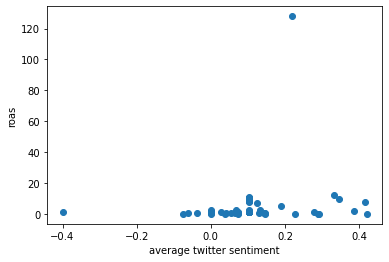

In [40]:
plt.scatter(x, y)
plt.ylabel('roas')
plt.xlabel('average twitter sentiment')

We see a positive correlation between twitter sentiment, In other words positive public opinion on twitter, and return on adspend. we will test this hypothesis to see if we can actually prove it.

test: does higher sentiment lead to higher roas?

H0: sentiment has no effect on roas.

H1: higher sentiment leads to higher roas.

p-value = 0.05

In [41]:
p_thresh = 0.05
sent = sorted(list(df['avg_polarity']))
negative = sent[:29]
positive = sent[-29:]

In [42]:
results = ttest_ind(positive, negative)

In [43]:
p = results[1] 
p < 0.05

True

In [44]:
results

Ttest_indResult(statistic=5.681418363383285, pvalue=4.983522763378712e-07)

In [45]:
max(negative), min(positive)

(0.10370384199999999, 0.10370384199999999)

We reject the null hypothesis and consider it reasonable that ourleads with positive sentiment above 0.1, on a scale on -1 to 1, have higher roas than those with sentiment below 0.1.

## insight

We should prioritize leads with average polarity above 0.1. This is because a company/product/service that is well recieved by the public is more likley to benefit from a solid marketing strategy, if a company is poorly recieved they likley have to fix their product / service and are less likley to benefit from optimizing their advertising.

# 6. what is the revenue of the leads with the highest ranked websites? run bootsrap sampling to see if there's a signifigant difference.

In [46]:
top5 = sorted(list(df['global']))[:5]
revenue_top5 = []
revenue_other = []
for i in range(len(df)):
    if df.iloc[i]['global'] in top5:
        revenue_top5.append(df.iloc[i]['revenue'])
    else:
        revenue_other.append(df.iloc[i]['revenue'])

In [47]:
bootstrap_top5 = []
bootstrap_other = []
for i in range(100):
    bootstrap_top5.append(np.mean(bootstrap(revenue_top5)))
    bootstrap_other.append(np.mean(bootstrap(revenue_other)))

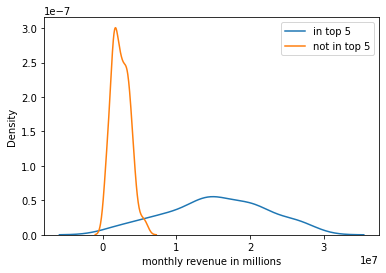

In [48]:
sns.kdeplot(x=bootstrap_top5, label='in top 5')
sns.kdeplot(x=bootstrap_other, label='not in top 5')
plt.xlabel('monthly revenue in millions')
plt.legend()

revenue for compaines with the top 5 highest ranked websites in the dataset looks notably higher, let's test it.

test: do the companies with the highest ranked websites generate more revenue than the rest of the companies?

H0: there is no association. 

H1: the companies with the highest ranked websites generate more revenue than the rest of the companies.

p-value: 0.05

In [49]:
chisquare(bootstrap_top5, f_exp=bootstrap_other) #we use chi square because we have large samples, an anova test may also be worth trying

Power_divergenceResult(statistic=12027061957.254923, pvalue=0.0)

We can reject the null hypothesis and consider it reasonable to believe that that the companies with the highest ranked websites generate more revenue than the other companies.

## insight

If we have prospects with websites ranked in the top 4000 most visited they are very likley to generate more revenue than the rest and are larger companies. This may give an opportunity to upsell or charge more.